# 1. Introduction

###### We are going to compare the following algorithms:
###### 1). Autoencoder 
###### 2). One-Class SVM 
###### 3). Isolation Forest 
###### 4). Local Outlier Factor 

In [1]:
# you can run this code in you terminal to create virtual environment
# python -m venv Anomaly

In [2]:
# then activate your virtual environment
# Anomaly\Scripts\Activate.ps1

In [3]:
#you may also want to upgrade your pip by running this code (similar execution for linux)
# python.exe -m pip install --upgrade pip

In [4]:
# Now put all your packages in the requirements.txt file and run it using this code
# pip3 install -r requirements.txt

In [49]:
# Now import your packages 
# Synthetic dataset
from sklearn.datasets import make_classification

#Data processing
import pandas as pd
import numpy as np
from collections import Counter

#Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.lines as mlines
from sklearn.inspection import DecisionBoundaryDisplay
import seaborn as sns

#Model and performance
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn import metrics

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# for autoencoder
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping




In [50]:
''' 
generate the data to be used for the anomaly detection. 
Generate a dataset with 1000 samples, 2 features, and a 99% to 1% class imbalance
X contains the feature data, y contains the labels (0 for normal, 1 for anomaly)
'''
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,n_repeated=0, weights=[0.99, 0.01], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [51]:
# confirm the class distribution
print(np.unique(y))
print(np.sum(y==0))
print(np.sum(y==1))

[0 1]
984
16


In [93]:
print((X_test[y_test==0].shape))
print((X_test[y_test==1].shape))

(326, 2)
(4, 2)


In [52]:
print((X_train[y_train==0].shape))
print((X_train[y_train==1].shape))

(658, 2)
(12, 2)


In [53]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [54]:
print((X_train[y_train==0].shape))
print((X_train[y_train==1].shape))

(658, 2)
(658, 2)


##### Now that we have our data set up, let's start fitting the models one by one

# 2). Autoencoder

#### Autoencoder is a bottle-neck type neural network that learns a compressed representation of the data by projecting it
#### down to a lower dimension.
#### Autoencoders are trained on normal data to learn the representation of the normal state. During inference, 
#### if an input significantly deviates from this learned representation, the AutoEncoder will likely reconstruct it poorly. 
#### and this poor reconstruction is a signal of an anomaly.

In [55]:
# since autoencoder is trained on normal data points, let isolate those
X_train_genuine = X_train[y_train == 0]
X_test_genuine = X_test[y_test==0]

X_train_anomaly = X_train[y_train==1]
X_test_anomaly = X_test[y_test==1]
print(X_train_genuine.shape)
print(X_train_anomaly.shape)
print(X_train_genuine[:4,:])

(658, 2)
(658, 2)
[[ 1.88262601 -0.37169182]
 [-0.54395666 -0.43555512]
 [-1.32338835 -2.12350652]
 [ 1.01923147 -1.21898021]]


In [56]:
# here is the encoder, to create the bottle-neck we use 64,32,16 layers and reconstruct the compression using 16,32, and 64.
CODE_DIM = 2
INPUT_SHAPE = X_train.shape[1]
input_layer = Input(shape=(INPUT_SHAPE,))
x = Dense(64, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
code = Dense(CODE_DIM, activation='relu')(x)
x = Dense(16, activation='relu')(code)
x = Dense(32, activation='relu')(x)
x = Dense(64, activation='relu')(x)
#output_layer = Dense(INPUT_SHAPE, activation='relu')(x)
output_layer = Dense(INPUT_SHAPE, activation='sigmoid')(x)
autoencoder = Model(input_layer, output_layer, name='anomaly')

In [57]:
# here is the training parameters
model_name = ".weights.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            save_weights_only=True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0,
                              patience = 15,
                              verbose = 1,
                              restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

In [58]:
# we compile
autoencoder.compile(loss='mae',
                    optimizer=Adam())

In [59]:
# and then the training
history = autoencoder.fit(X_train_genuine, X_train_genuine,
                          epochs=65, batch_size=64,
                          validation_data=(X_test, X_test),
                          callbacks=callbacks, shuffle=True)

Epoch 1/65
 1/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - loss: 1.2196
Epoch 1: val_loss improved from inf to 1.33777, saving model to .weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 1.3364 - val_loss: 1.3378
Epoch 2/65
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.3903
Epoch 2: val_loss improved from 1.33777 to 1.28714, saving model to .weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3311 - val_loss: 1.2871
Epoch 3/65
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.2700
Epoch 3: val_loss improved from 1.28714 to 1.20011, saving model to .weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2724 - val_loss: 1.2001
Epoch 4/65
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.2404
Epoch 4: val_loss improved from 1.20011 to 1.13813, saving model to .weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1706 - val_loss: 1.1381
Epoch 5/65
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.1380
Epoch 5: val_loss improved from 1.13813 to 1.11874, saving 

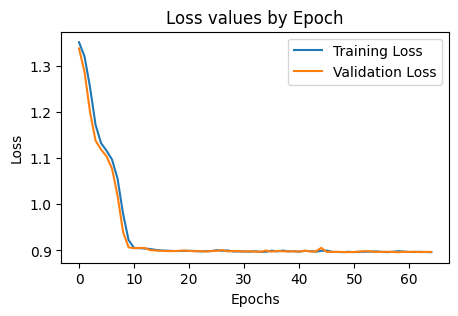

In [99]:
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

In [61]:
reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)

In [62]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)
recons_df.head()

,error,y_true
0,1.914206,0
1,1.268877,0
2,0.289138,0
3,0.605847,0
4,0.565138,0


In [63]:
# find threshold 
def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        if i%100 == 0:
          print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

In [64]:
thresh_df = thresholdTuning(recons_df, 1000)

Threshold: 0.0256	Accuracy: 0.015		Precision: 0.506	Recall Score: 0.502
Threshold: 0.3362	Accuracy: 0.100		Precision: 0.473	Recall Score: 0.298
Threshold: 0.4644	Accuracy: 0.200		Precision: 0.489	Recall Score: 0.348
Threshold: 0.5671	Accuracy: 0.294		Precision: 0.487	Recall Score: 0.272
Threshold: 0.6738	Accuracy: 0.394		Precision: 0.491	Recall Score: 0.323
Threshold: 0.7727	Accuracy: 0.494		Precision: 0.494	Recall Score: 0.373
Threshold: 0.9146	Accuracy: 0.594		Precision: 0.496	Recall Score: 0.424
Threshold: 1.0894	Accuracy: 0.694		Precision: 0.499	Recall Score: 0.475
Threshold: 1.3304	Accuracy: 0.794		Precision: 0.502	Recall Score: 0.525
Threshold: 1.6404	Accuracy: 0.888		Precision: 0.493	Recall Score: 0.449


In [65]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 1.354601


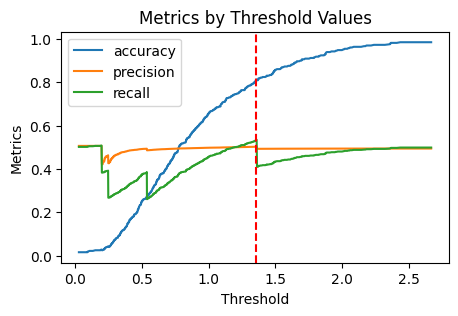

In [98]:
plt.figure(figsize=(5,3))
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics by Threshold Values')
plt.legend()
plt.show()

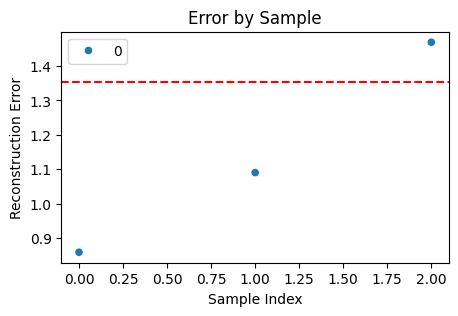

In [97]:
temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(5,3))
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Error by Sample')
plt.legend()
plt.show()

In [68]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df.head()

,error,y_true,y_pred
0,1.914206,0,True
1,1.268877,0,False
2,0.289138,0,False
3,0.605847,0,False
4,0.565138,0,False


In [69]:
print(classification_report(recons_df['y_true'],recons_df['y_pred']))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90       326
           1       0.02      0.25      0.03         4

    accuracy                           0.81       330
   macro avg       0.50      0.53      0.46       330
weighted avg       0.98      0.81      0.89       330



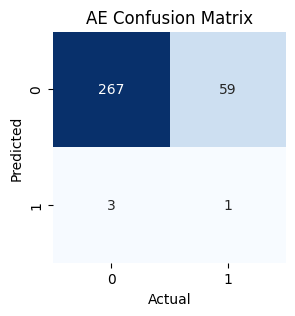

In [94]:
cm = metrics.confusion_matrix(recons_df['y_true'],recons_df['y_pred'])
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('AE Confusion Matrix')
plt.show()

In [71]:
# Calculate the accuracty and other classification metrics
AE_accuracy = metrics.accuracy_score(recons_df['y_true'], recons_df['y_pred'])
AE_precision = metrics.precision_score(recons_df['y_true'], recons_df['y_pred'], average="micro")
AE_recall = metrics.recall_score(recons_df['y_true'], recons_df['y_pred'], average="micro")
AE_f1score = metrics.f1_score(recons_df['y_true'], recons_df['y_pred'], average="micro")
#lr_classification_rep = classification_report(y_test, lr_pred, target_names=data.target_names)

In [72]:

# Lets print the results
print(f"Accuracy: {AE_accuracy:.2f}")
print(f"precision: {AE_precision:.2f}")
print(f"Recall: {AE_recall:.2f}")
print(f"F1Score: {AE_f1score:.2f}")
#print(f"Classification Report:")
#print(lr_classification_rep)

Accuracy: 0.81
precision: 0.81
Recall: 0.81
F1Score: 0.81


In [73]:
AE_scores = [AE_accuracy, AE_precision, AE_recall,AE_f1score]
print(AE_scores)

[0.8121212121212121, 0.8121212121212121, 0.8121212121212121, 0.8121212121212121]


# 3). One-Class-SVM

#### It works by learning a decision boundary around the training data, which is assumed to represent the "normal" behavior. 
#### The algorithm maps data into a high-dimensional space using a kernel function and then finds a hyperplane that maximally 
#### separates the origin from the normal data points, enclosing them within a boundary. Any new data point falling outside this 
#### boundary is classified as an anomaly. The algorithm is effective in high-dimensional spaces and when anomalies are rare and 
#### distinctly different from normal data.

In [74]:

# fit the model
#SVM_model = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
SVM_model = OneClassSVM(nu=0.001, kernel="rbf", gamma=0.001)
SVM_model.fit(X_train)
#y_pred_train_SVM = SVM_model.predict(X_train)
y_pred_test_SVM = SVM_model.predict(X_test)
#y_pred_outliers_SVM = SVM_model.predict(X_train_anomaly)
#n_error_train = y_pred_train_SVM[y_pred_train_SVM == -1].size
n_error_test = y_pred_test_SVM[y_pred_test_SVM == -1].size
#n_error_outliers = y_pred_outliers_SVM[y_pred_outliers_SVM == 1].size

In [75]:
print(y_pred_test_SVM)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [76]:
# By default, one-class SVM labels the normal data points as 1s and anomalies as -1s.
#Change the anomalies' values and to make it consistent with the true values
y_pred_test_SVM = [1 if i==-1 else 0 for i in y_pred_test_SVM]
print(y_pred_test_SVM)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


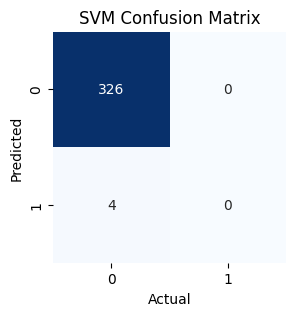

In [100]:
cm = metrics.confusion_matrix(y_test, y_pred_test_SVM)
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('SVM Confusion Matrix')
plt.show()

In [78]:
# Calculate the accuracty and other classification metrics
SVM_accuracy = metrics.accuracy_score(y_test, y_pred_test_SVM)
SVM_precision = metrics.precision_score(y_test, y_pred_test_SVM, average="micro")
SVM_recall = metrics.recall_score(y_test, y_pred_test_SVM, average="micro")
SVM_f1score = metrics.f1_score(y_test, y_pred_test_SVM, average="micro")
#lr_classification_rep = classification_report(y_test, lr_pred, target_names=data.target_names)

# Lets print the results
print(f"Accuracy: {SVM_accuracy:.2f}")
print(f"precision: {SVM_precision:.2f}")
print(f"Recall: {SVM_recall:.2f}")
print(f"F1Score: {SVM_f1score:.2f}")
#print(f"Classification Report:")
#print(lr_classification_rep)

Accuracy: 0.99
precision: 0.99
Recall: 0.99
F1Score: 0.99


In [79]:
SVM_scores = [SVM_accuracy, SVM_precision, SVM_recall,SVM_f1score]
print(SVM_scores)

[0.9878787878787879, 0.9878787878787879, 0.9878787878787879, 0.9878787878787879]


# 4). Isolation Forest

#### works by recursively partitioning the data using random feature splits to construct a tree structure. Anomalies, 
#### being few and distinct, tend to be isolated quickly with fewer splits, resulting in shorter path lengths in the tree. 
#### The algorithm builds an ensemble of such random trees (a forest) and calculates the average path length for each data point 
#### across the trees. Points with shorter average path lengths are more likely to be anomalies. This approach is computationally 
#### efficient and effective for high-dimensional datasets.

In [80]:
# initialize and fit the model
clf_IF = IsolationForest(contamination=0.1)
clf_IF.fit(X_train)

IsolationForest(contamination=0.1)

In [81]:
# predict the anomalies in the data
y_pred_train_IF = clf_IF.predict(X_train)
y_pred_test_IF = clf_IF.predict(X_test)
print(y_pred_train_IF)
print(y_pred_test_IF)

[1 1 1 ... 1 1 1]
[ 1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1 -1  1  1 -1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1 -1  1  1  1  1  1
 -1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1
  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1
  1  1  1  1  1  1  1 -1  1  1  1

In [82]:
y_pred_test_IF = [1 if i==-1 else 0 for i in y_pred_test_IF]

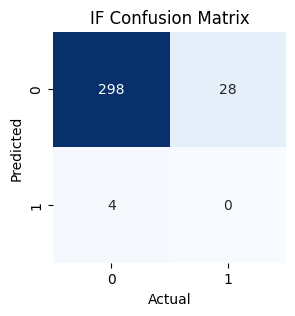

In [101]:
cm = metrics.confusion_matrix(y_test, y_pred_test_IF)
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('IF Confusion Matrix')
plt.show()

In [84]:
# Calculate the accuracty and other classification metrics
IF_accuracy = metrics.accuracy_score(y_test, y_pred_test_IF)
IF_precision = metrics.precision_score(y_test, y_pred_test_IF, average="micro")
IF_recall = metrics.recall_score(y_test, y_pred_test_IF, average="micro")
IF_f1score = metrics.f1_score(y_test, y_pred_test_IF, average="micro")
#lr_classification_rep = classification_report(y_test, lr_pred, target_names=data.target_names)

# Lets print the results
print(f"Accuracy: {IF_accuracy:.2f}")
print(f"precision: {IF_precision:.2f}")
print(f"Recall: {IF_recall:.2f}")
print(f"F1Score: {IF_f1score:.2f}")
#print(f"Classification Report:")
#print(lr_classification_rep)

Accuracy: 0.90
precision: 0.90
Recall: 0.90
F1Score: 0.90


In [85]:
IF_scores = [IF_accuracy, IF_precision, IF_recall,IF_f1score]
print(IF_scores)

[0.9030303030303031, 0.9030303030303031, 0.9030303030303031, 0.9030303030303031]


# 5). Local Outlier Factor (LOF)

#### It  detects anomalies by measuring the local density of data points and identifying those with significantly lower
####  density compared to their neighbors. For each data point, LOF calculates a "local reachability density" based on the distance
####  to its nearest neighbors and compares this density with the densities of those neighbors. Points with a substantially lower 
#### density relative to their neighbors are considered anomalies, as they are less similar to their surrounding data. LOF is effective 
#### for datasets with varying density regions, as it focuses on local context rather than a global threshold for anomaly detection.

In [86]:

# Load the dataset
#X, y = load_breast_cancer(return_X_y=True)
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
# Create the LocalOutlierFactor model for outlier detection
lof_outlier = LocalOutlierFactor(n_neighbors=20)
# Fit the model to the data and predict
# the outlier scores for each data point
outlier_scores = lof_outlier.fit_predict(X_train_scaled)

# Identify the outlier data points
#outlier_indices = outlier_scores == -1
#print("Outlier indices:", outlier_indices)

lof_novelty = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof_novelty.fit(X_train_scaled)

# Use the model to predict whether new data points are novelties
y_test_pred_LOF = lof_novelty.predict(X_test_scaled)
print("Novelty detection for new data point:", y_test_pred_LOF)


Novelty detection for new data point: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1 -1  1
 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1 -1
  1  1  1  1 

In [87]:
y_test_pred_LOF = [1 if i==-1 else 0 for i in y_test_pred_LOF]

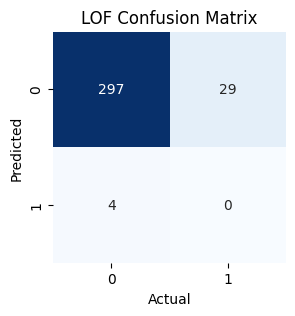

In [102]:
cm = metrics.confusion_matrix(y_test, y_test_pred_LOF)
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('LOF Confusion Matrix')
plt.show()

In [89]:
# Calculate the accuracty and other classification metrics
LOF_accuracy = metrics.accuracy_score(y_test, y_test_pred_LOF)
LOF_precision = metrics.precision_score(y_test, y_test_pred_LOF, average="micro")
LOF_recall = metrics.recall_score(y_test, y_test_pred_LOF, average="micro")
LOF_f1score = metrics.f1_score(y_test, y_test_pred_LOF, average="micro")
#lr_classification_rep = classification_report(y_test, lr_pred, target_names=data.target_names)

# Lets print the results
print(f"Accuracy: {LOF_accuracy:.2f}")
print(f"precision: {LOF_precision:.2f}")
print(f"Recall: {LOF_recall:.2f}")
print(f"F1Score: {LOF_f1score:.2f}")
#print(f"Classification Report:")
#print(lr_classification_rep)

Accuracy: 0.90
precision: 0.90
Recall: 0.90
F1Score: 0.90


In [90]:
LOF_scores = [LOF_accuracy, LOF_precision, LOF_recall,LOF_f1score]
print(LOF_scores)

[0.9, 0.9, 0.9, 0.9]


# 6). The metrics

In [91]:
metrics_df = pd.DataFrame({"AE":AE_scores, "IF":IF_scores, "SVM":SVM_scores, "LOF":LOF_scores})
print(metrics_df)

         AE       IF       SVM  LOF
0  0.812121  0.90303  0.987879  0.9
1  0.812121  0.90303  0.987879  0.9
2  0.812121  0.90303  0.987879  0.9
3  0.812121  0.90303  0.987879  0.9


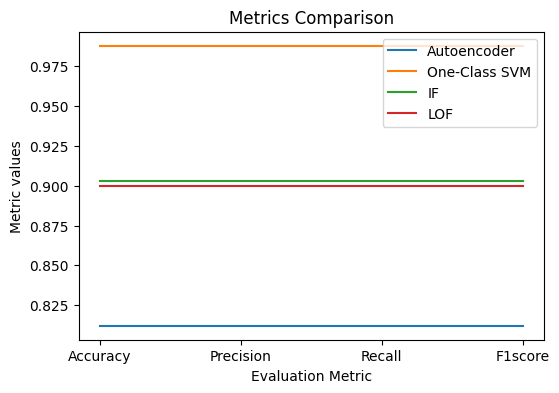

In [103]:
categories = ["Accuracy", "Precision", "Recall", "F1score"]
plt.figure(figsize=(6,4))
plt.plot(categories, AE_scores, label='Autoencoder')
plt.plot(categories, SVM_scores, label='One-Class SVM')
plt.plot(categories, IF_scores, label='IF')
plt.plot(categories, LOF_scores, label='LOF')
plt.xlabel('Evaluation Metric')
plt.ylabel('Metric values')
plt.title('Metrics Comparison')
plt.legend()
plt.show()

# 7). Conclusion

#### 1). SVM performs very well
#### 2). Hyper-parameter tunning is needed in all the algorithms to improve performance.
#### 3). The dataset was highly imbalanced and therefore micro-averaging was used.